In [1]:
import pandas as pd
from surprise import Reader, Dataset, SVD, model_selection, accuracy
from surprise.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


ratings = pd.read_csv("ml-25m/ratings.csv") 

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
#Filter data to include movies with at least 14500 ratings and users with at least 250 ratings

data = ratings.groupby('movieId').filter(lambda x: len(x) >= 14500)
data = data.groupby('userId').filter(lambda x: len(x) >= 250)

In [3]:
#Set up a surprise reader to read in data properly

reader = Reader()

In [4]:
#Create training and test sets

data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=.2)

In [5]:
#Create arrays for number of dimensions and RMSEs

dimension_array = np.array((10,20,30,40,50,60,70,80,90,100))
rmse_mean_array = np.zeros((dimension_array.shape))

In [6]:
#Iterate through each number of dimensions using SVD to minimize the RMSE through cross validation
for idx,i in enumerate(dimension_array):
    svd = SVD(n_factors = i)
    rmse_array = model_selection.cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=False)
    rmse_mean = np.mean(rmse_array['test_rmse'])
    rmse_mean_array[idx] = rmse_mean
    print('Number of Dimensions: ', i, ' Validation RMSE: ', rmse_mean)

Number of Dimensions:  10  Validation RMSE:  0.7107260624821977
Number of Dimensions:  20  Validation RMSE:  0.702519360386375
Number of Dimensions:  30  Validation RMSE:  0.698845810493497
Number of Dimensions:  40  Validation RMSE:  0.696400059414706
Number of Dimensions:  50  Validation RMSE:  0.695051055048436
Number of Dimensions:  60  Validation RMSE:  0.693575390439468
Number of Dimensions:  70  Validation RMSE:  0.6928634041585688
Number of Dimensions:  80  Validation RMSE:  0.6920549547435055
Number of Dimensions:  90  Validation RMSE:  0.691662954284936
Number of Dimensions:  100  Validation RMSE:  0.6913427674307979


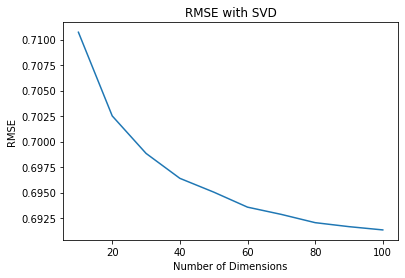

In [7]:
#Plot how RMSE changes with number of dimensions

plt.plot(dimension_array, rmse_mean_array)
plt.title('RMSE with SVD')
plt.xlabel('Number of Dimensions')
plt.ylabel('RMSE')
plt.show()

In [16]:
#Find the optimal number of dimensions (minimize RMSE until it starts to plateau)

# min_rmse_idx = np.argmin(rmse_mean_array)
# optimal_dimension = dimension_array[min_rmse_idx]
# print('Number of Dimensions: ', optimal_dimension)

for idx in range(1,dimension_array.shape[0]):
    if (rmse_mean_array[idx-1] - rmse_mean_array[idx]) < 0.001:
        optimal_dimension = dimension_array[idx-1]
        break
print('Optimal Number of Dimensions: ', optimal_dimension)


#Create the final model using SVD and calculate the RMSE on the validation set

svd = SVD(n_factors = optimal_dimension)
rmse_array = model_selection.cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=False)
print('Validation RMSE: ', np.mean(rmse_array['test_rmse']))

Optimal Number of Dimensions:  60
Validation RMSE:  0.6932832613093342


In [17]:
#Fit the optimal model to the training set

svd.fit(trainset)

In [18]:
#Make predictions on the test set and calculate the test set RMSE

predictions = svd.test(testset)
df = pd.DataFrame(predictions)

print('Test RMSE: ', accuracy.rmse(predictions))

RMSE: 0.6936
Test RMSE:  0.6935619524234605


In [19]:
#Create new user IDs to match initial ones

userID_list = df['uid'].unique()

new_uid = np.zeros((len(df),1))
for i in range(len(df)):
  new_uid[i,] = np.where(userID_list == df['uid'].iloc[i])

df['uid2'] = new_uid

In [20]:
#Find top 25 recommended movies for each user

recommendations_indices = np.zeros(shape = (len(userID_list),25))

for i in range(0,len(userID_list)):
    userdf = df[df['uid2']==i]
    top = userdf.nlargest(25, 'est')
    recommendations = top['iid']
    recommendations_indices[i,:] = recommendations.values

In [21]:
#Calculate average precision, recall, and F1 scores

precision_matrix = np.zeros(shape=(len(userID_list)))
recall_matrix = np.zeros(shape=(len(userID_list)))
f1_matrix = np.zeros(shape=(len(userID_list)))

for idx,i in enumerate(userID_list):
    userdf = df[df['uid2']==idx]
    top_movies_rated = userdf[userdf['r_ui']>=3.5]

    top_rated_indices = top_movies_rated['iid'].values
    
    tp = len(np.intersect1d(recommendations_indices[idx,:], top_rated_indices))
    fp = len(recommendations_indices)-tp
    fn = len(top_rated_indices)-tp

    precision = tp / (tp + fp + 1e-10)
    precision_matrix[idx] = precision
    recall = tp / (tp + fn + 1e-10)
    recall_matrix[idx] = recall

    f1 = 2.0 * (precision * recall) / (precision + recall + 1e-10)
    f1_matrix[idx] = f1


avg_precision = np.average(precision_matrix)
avg_recall = np.average(recall_matrix)
avg_f1 = np.average(f1_matrix)
print('Average Precision: ', avg_precision)
print('Average Recall: ', avg_recall)
print('Average F1 Score: ', avg_f1)

Average Precision:  0.01444959851096553
Average Recall:  0.604550878118764
Average F1 Score:  0.028165961144389188
